In [1]:
import astropy.units as u
import astropy.constants as const
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

In [2]:
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator

color_map = {
    "green1": "#66c2a5",
    "orange": "#fc8d62",
    "blue": "#8da0cb",
    "pink": "#e78ac3",
    "green2": "#a6d854",
    "yellow": "#ffd92f",
    "brown": "#e5c494",
    "grey": "#b3b3b3",
}

In [3]:
import glob
import os
import sys
sys.path.append('../tools/')

from dust_extinction import calALambda
from spec_to_flux import spec_to_flux, spec_to_mag
from data_binning import data_binning
from visual import rcparams_format

rcparams_format(mpl.rcParams)

## Distance modulus

In [4]:
# SN metadata

z = 0.02736
z_unc = 0.00007
t_max_mjd = 59723.65 # t_0 in salt3
ebv = 0.032
rv = 3.1

# tfl = 58972.46296299994


### IPAC velocity calculator

- $z=0.02736$, $v = cz = 8202.3$ km/s, $v_\mathrm{CMB} = 8346.4$ km/s

### Cosmic flow

- $\Omega_M=0.3$, $h_0=0.7$

In [5]:
cosmo = np.loadtxt('SN2022joj_cosmo.txt')
print('Luminosity distances =', cosmo[6], 'Mpc')

mu = 5 * np.log10(cosmo[6] * 1e6 / 10)
print('Distance modulus = {:.2f}'.format(mu))


Luminosity distances = 119.49 Mpc
Distance modulus = 35.39


## Light curves

In [6]:
import pandas as pd
from astropy.table import Table

In [7]:
joj_ZTF = pd.read_csv('./ZTF22aajijjf_forced_fnu.csv')
joj_ZTF['MJD'] = joj_ZTF['jd'] - 2400000.5
joj_ZTF['phase'] = (joj_ZTF['MJD'] - t_max_mjd) / (1 + z)
joj_ZTF['fnu_microJy'] = joj_ZTF['fnu_microJy'] * (1 + z)
joj_ZTF['fnu_microJy_unc'] = joj_ZTF['fnu_microJy_unc'] * (1 + z)
arg = (joj_ZTF['phase'] <= 150) & (joj_ZTF['phase'] >= -25)
joj_ZTF = joj_ZTF[arg]
joj_ZTF['mag'] = -2.5 * np.log10(joj_ZTF['fnu_microJy'] * 1e-6/3631)
joj_ZTF['mag_err_u'] = -2.5 * np.log10((joj_ZTF['fnu_microJy'] - joj_ZTF['fnu_microJy_unc']) * 1e-6/3631) - joj_ZTF['mag']
joj_ZTF['mag_err_l'] = 2.5 * np.log10((joj_ZTF['fnu_microJy'] + joj_ZTF['fnu_microJy_unc']) * 1e-6/3631) + joj_ZTF['mag']
joj_ZTF_g = joj_ZTF[joj_ZTF['passband'] == 'ZTF_g'].assign(passband='ztfg')
joj_ZTF_r = joj_ZTF[joj_ZTF['passband'] == 'ZTF_r'].assign(passband='ztfr')
joj_ZTF_i = joj_ZTF[joj_ZTF['passband'] == 'ZTF_i'].assign(passband='ztfi')
joj_ZTF = pd.concat([joj_ZTF_g, joj_ZTF_r, joj_ZTF_i])


/Users/chang/miniconda3/envs/astron/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/chang/miniconda3/envs/astron/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/chang/miniconda3/envs/astron/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [8]:
# joj_ZTF = joj_ZTF[~np.isnan(joj_ZTF['mag'])]
joj_ZTF_g = joj_ZTF[joj_ZTF['passband'] == 'ztfg']
joj_ZTF_r = joj_ZTF[joj_ZTF['passband'] == 'ztfr']
joj_ZTF_i = joj_ZTF[joj_ZTF['passband'] == 'ztfi']

In [9]:
# UVOT
joj_UVOT = pd.read_csv(
    "./UVOT_light_curve.dat",
    delimiter=" ",
    names=["time", "flux", "fluxerr", "mag", "mag_unc_u", "mag_unc_l", "lim", "band"],
)
joj_UVOT_u = joj_UVOT[joj_UVOT["band"] == "U"]
joj_UVOT_b = joj_UVOT[joj_UVOT["band"] == "B"]
joj_UVOT_v = joj_UVOT[joj_UVOT["band"] == "V"]
joj_UVOT_u = joj_UVOT[joj_UVOT["band"] == "U"].assign(band="uvot::u")
joj_UVOT_b = joj_UVOT[joj_UVOT["band"] == "B"].assign(band="uvot::b")
joj_UVOT_v = joj_UVOT[joj_UVOT["band"] == "V"].assign(band="uvot::v")
joj_UVOT = pd.concat([joj_UVOT_b, joj_UVOT_v])

In [10]:
# ATLAS
joj_ATLAS = pd.read_csv("./atlas_forced_phot.txt", delimiter=" ", names=["MJD", "m", "dm", "uJy", "duJy", "F", "err", "chi/N", "RA", "Dec", "x", "y", "maj", "min", "phi", "apfit", "mag5sig", "Sky", "Obs"])
joj_ATLAS = np.loadtxt("./atlas_forced_phot.txt", dtype=object)
# joj_ATLAS = joj_ATLAS[:, [0, 2, 3, ]]
joj_ATLAS = joj_ATLAS[:, [0, 3, 4, 5]]
joj_ATLAS[:, :-1] = np.array(joj_ATLAS[:, :-1], dtype=float)
joj_ATLAS_o = joj_ATLAS[joj_ATLAS[:, -1] == "o"]
arg = ((joj_ATLAS_o[:, 0] - t_max_mjd) / (1 + z) <= 48) & ((joj_ATLAS_o[:, 0] - t_max_mjd) / (1 + z) >= -48)
joj_ATLAS_o[:, -1] = "atlaso"
joj_ATLAS_o = joj_ATLAS_o[arg]
joj_ATLAS_o = pd.DataFrame(joj_ATLAS_o, columns=["time", "flux", "fluxerr", "band"])

## Early rise

In [11]:
import pymc as pm
import arviz as az

In [12]:
joj_ZTF_r_rise = joj_ZTF_r[
    ((joj_ZTF_r["MJD"] - t_max_mjd) / (1 + z) <= 0)
    & ((joj_ZTF_r["MJD"] - t_max_mjd) / (1 + z) >= -25)
    & (joj_ZTF_r["fnu_microJy"]/joj_ZTF_r["fnu_microJy"].max() <= 0.4)
]

In [13]:
### MJD          m      dm   uJy   duJy F err chi/N     RA       Dec        x        y     maj  min   phi  apfit mag5sig Sky   Obs
with open("./atlas_forced_phot.txt") as f:
    lines = f.readlines()
joj_ATLAS = {"MJD":[], "fnu_microJy":[], "fnu_microJy_unc":[], "passband":[]}
for l in lines[1:]:
    dat = l.split()
    joj_ATLAS["MJD"] = np.append(joj_ATLAS["MJD"], float(dat[0]))
    joj_ATLAS["fnu_microJy"] = np.append(joj_ATLAS["fnu_microJy"], float(dat[3]))
    joj_ATLAS["fnu_microJy_unc"] = np.append(joj_ATLAS["fnu_microJy_unc"], float(dat[4]))
    joj_ATLAS["passband"] = np.append(joj_ATLAS["passband"], dat[5])
joj_ATLAS = pd.DataFrame(joj_ATLAS)
joj_ATLAS_o = joj_ATLAS[joj_ATLAS["passband"] == "o"]
joj_ATLAS_o_rise = joj_ATLAS_o[
    ((joj_ATLAS_o["MJD"] - t_max_mjd) / (1 + z) <= 0)
    & ((joj_ATLAS_o["MJD"] - t_max_mjd) / (1 + z) >= -25)
    & (joj_ATLAS_o["fnu_microJy"]/joj_ATLAS_o["fnu_microJy"].max() <= 0.4)
]

In [25]:
MJD_pred = np.linspace(-25, -10, 100) + t_max_mjd
with pm.Model() as rise_MJD:
    t_exp = pm.Uniform(
        "t_exp", joj_ZTF_r_rise["MJD"].values[0], joj_ZTF_r_rise["MJD"].values[-1]
    )
    alpha_ZTF = pm.Normal("alpha_ZTF", 2, 1)
    log_A_ZTF = pm.Uniform("log_A_ZTF", 0, 2)
    phase_ZTF = joj_ZTF_r_rise["MJD"].values - t_exp
    flux_ZTF = pm.Deterministic(
        "flux_ZTF", 10**log_A_ZTF * ((phase_ZTF + np.abs(phase_ZTF)) / 2) ** alpha_ZTF
    )
    alpha_ATLAS = pm.Normal("alpha_ATLAS", 2, 1)
    log_A_ATLAS = pm.Uniform("log_A_ATLAS", 0, 2)
    phase_ATLAS = joj_ATLAS_o_rise["MJD"].values - t_exp
    flux_ATLAS = pm.Deterministic(
        "flux_ATLAS",
        10**log_A_ATLAS * ((phase_ATLAS + np.abs(phase_ATLAS)) / 2) ** alpha_ATLAS,
    )
    flux_obs_ZTF = pm.Normal(
        "flux_obs_ZTF",
        flux_ZTF,
        joj_ZTF_r_rise["fnu_microJy_unc"].values,
        observed=joj_ZTF_r_rise["fnu_microJy"].values,
    )
    flux_obs_ATLAS = pm.Normal(
        "flux_obs_ATLAS",
        flux_ATLAS,
        joj_ATLAS_o_rise["fnu_microJy_unc"].values,
        observed=joj_ATLAS_o_rise["fnu_microJy"].values,
    )
    flux_pred_ZTF = pm.Deterministic(
        "flux_pred_ZTF",
        10**log_A_ZTF
        * (((MJD_pred - t_exp) + np.abs(MJD_pred - t_exp)) / 2) ** alpha_ZTF,
    )
    flux_pred_ATLAS = pm.Deterministic(
        "flux_pred_ATLAS",
        10**log_A_ATLAS
        * (((MJD_pred - t_exp) + np.abs(MJD_pred - t_exp)) / 2) ** alpha_ATLAS,
    )
    trace_MJD = pm.sample(return_inferencedata=True, tune=5000, target_accept=0.95)

with pm.Model() as rise_alpha2_MJD:
    t_exp = pm.Uniform(
        "t_exp", joj_ZTF_r_rise["MJD"].values[0], joj_ZTF_r_rise["MJD"].values[-1]
    )
    alpha_ZTF = 2
    log_A_ZTF = pm.Uniform("log_A_ZTF", 0, 2)
    phase_ZTF = (joj_ZTF_r_rise["MJD"].values - t_exp)
    flux_ZTF = pm.Deterministic(
        "flux_ZTF", 10**log_A_ZTF * ((phase_ZTF + np.abs(phase_ZTF)) / 2) ** alpha_ZTF
    )
    alpha_ATLAS = 2
    log_A_ATLAS = pm.Uniform("log_A_ATLAS", 0, 2)
    phase_ATLAS = (joj_ATLAS_o_rise["MJD"].values - t_exp)
    flux_ATLAS = pm.Deterministic(
        "flux_ATLAS",
        10**log_A_ATLAS * ((phase_ATLAS + np.abs(phase_ATLAS)) / 2) ** alpha_ATLAS,
    )
    flux_obs_ZTF = pm.Normal(
        "flux_obs_ZTF",
        flux_ZTF,
        joj_ZTF_r_rise["fnu_microJy_unc"].values,
        observed=joj_ZTF_r_rise["fnu_microJy"].values,
    )
    flux_obs_ATLAS = pm.Normal(
        "flux_obs_ATLAS",
        flux_ATLAS,
        joj_ATLAS_o_rise["fnu_microJy_unc"].values,
        observed=joj_ATLAS_o_rise["fnu_microJy"].values,
    )
    flux_pred_ZTF = pm.Deterministic(
        "flux_pred_ZTF",
        10**log_A_ZTF
        * (((MJD_pred - t_exp) + np.abs(MJD_pred - t_exp)) / 2) ** alpha_ZTF,
    )
    flux_pred_ATLAS = pm.Deterministic(
        "flux_pred_ATLAS",
        10**log_A_ATLAS
        * (((MJD_pred - t_exp) + np.abs(MJD_pred - t_exp)) / 2)
        ** alpha_ATLAS,
    )
    trace_MJD_alpha2 = pm.sample(return_inferencedata=True, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t_exp, alpha_ZTF, log_A_ZTF, alpha_ATLAS, log_A_ATLAS]


Sampling 4 chains for 5_000 tune and 1_000 draw iterations (20_000 + 4_000 draws total) took 111 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t_exp, log_A_ZTF, log_A_ATLAS]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 16 seconds.


In [26]:
summary = az.summary(trace_MJD, hdi_prob=0.68, var_names=[var for var in trace_MJD.posterior.data_vars if not 'flux' in var])
summary_pred = az.summary(trace_MJD, hdi_prob=0.68, var_names=[var for var in trace_MJD.posterior.data_vars if 'pred' in var])
summary

/Users/chang/miniconda3/envs/astron/lib/python3.10/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/chang/miniconda3/envs/astron/lib/python3.10/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_16%,hdi_84%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_ZTF,2.179,0.209,1.944,2.384,0.008,0.005,749.0,970.0,1.0
alpha_ATLAS,2.312,0.360,2.113,2.789,0.012,0.008,939.0,1112.0,1.0
t_exp,59703.158,0.600,59702.583,59703.855,0.022,0.015,761.0,1100.0,1.0
log_A_ZTF,0.567,0.258,0.321,0.866,0.009,0.007,746.0,983.0,1.0
log_A_ATLAS,0.446,0.327,0.000,0.560,0.011,0.008,833.0,1069.0,1.0


In [24]:
summary_alpha2 = az.summary(trace_MJD_alpha2, hdi_prob=0.68, var_names=[var for var in trace_MJD_alpha2.posterior.data_vars if not 'flux' in var])
summary_alpha2_pred = az.summary(trace_MJD_alpha2, hdi_prob=0.68, var_names=[var for var in trace_MJD_alpha2.posterior.data_vars if 'pred' in var])
summary_alpha2

/Users/chang/miniconda3/envs/astron/lib/python3.10/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/chang/miniconda3/envs/astron/lib/python3.10/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_16%,hdi_84%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
t_exp,59703.658,0.111,59703.548,59703.765,0.003,0.002,1151.0,1307.0,1.0
log_A_ZTF,0.788,0.015,0.774,0.804,0.000,0.000,1144.0,1160.0,1.0
log_A_ATLAS,0.778,0.023,0.757,0.802,0.001,0.000,1448.0,1594.0,1.0


In [20]:
t_fl_mjd = 59703.136
t_fl_mjd_up, t_fl_mjd_lo = 59703.759, 59702.566
t_max_mjd_B = 59723.13
rise_time = (t_max_mjd_B - t_fl_mjd) / (1 + z)
rise_time

19.461532471576444

(-50.0, 550.0)

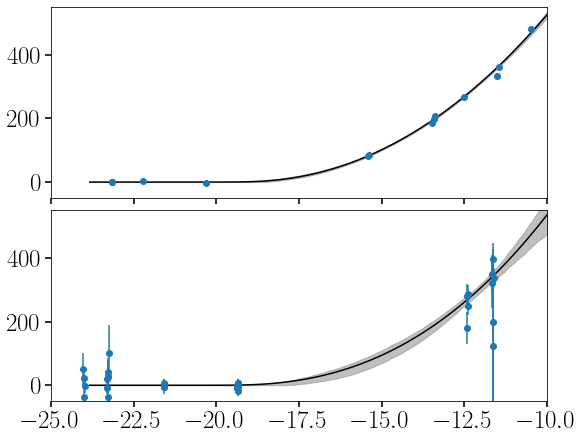

In [27]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True, constrained_layout=True)
pred_ZTF = summary_pred.loc[summary_pred.index[:100]]
pred_ATLAS = summary_pred.loc[summary_pred.index[100:]]
ax[0].plot((MJD_pred - t_max_mjd_B) / (1 + z), pred_ZTF["mean"], color="k")
ax[0].fill_between(
    (MJD_pred - t_max_mjd_B) / (1 + z), pred_ZTF["hdi_16%"], pred_ZTF["hdi_84%"], color="0.5", alpha=0.5
)
ax[0].errorbar(
    (joj_ZTF_r_rise["MJD"].values - t_max_mjd_B) / (1 + z),
    joj_ZTF_r_rise["fnu_microJy"].values,
    yerr=joj_ZTF_r_rise["fnu_microJy_unc"].values,
    fmt="o",
)
ax[1].plot((MJD_pred - t_max_mjd_B) / (1 + z), pred_ATLAS["mean"], color="k")
ax[1].fill_between(
    (MJD_pred - t_max_mjd_B) / (1 + z), pred_ATLAS["hdi_16%"], pred_ATLAS["hdi_84%"], color="0.5", alpha=0.5
)
ax[1].errorbar(
    (joj_ATLAS_o_rise["MJD"].values - t_max_mjd_B) / (1 + z),
    joj_ATLAS_o_rise["fnu_microJy"].values,
    yerr=joj_ATLAS_o_rise["fnu_microJy_unc"].values,
    fmt="o",
)
# plt.yscale('log')
plt.xlim(-25, -10)
ax[0].set_ylim(-50, 550)
ax[1].set_ylim(-50, 550)
# plt.yscale("log")

### Polynomial

In [86]:
def peak_poly_fit(MJD, mag_obs, mag_obs_unc, z=0, t_max_0=59723):
    MJD_pred = np.linspace(-10, 20, 100) + t_max_0
    with pm.Model() as peak:
        # t_max = pm.Uniform("t_max", 59721, 59724)
        t_max = pm.Normal("t_max", t_max_0, 5)

        a4 = pm.Uniform("a4", -1e-2, 1e-2)
        a3 = pm.Uniform("a3", -1e-2, 1e-2)
        a2 = pm.Uniform("a2", -1e-2, 1e-2)
        a0 = pm.Uniform("a0", mag_obs.min() - 0.5, mag_obs.min() + 0.5)

        phase = (MJD - t_max) / (1 + z)
        phase_pred = (MJD_pred - t_max) / (1 + z)
        mag = pm.Deterministic(
            "mag",
            a4 * phase**4 + a3 * phase**3 + a2 * phase**2 + a0,
        )
        mag_obs = pm.Normal("mag_obs", mag, mag_obs_unc, observed=mag_obs)
        mag_pred = pm.Deterministic(
            "mag_pred",
            a4 * phase_pred**4 + a3 * phase_pred**3 + a2 * phase_pred**2 + a0,
        )
        dt = 15
        delta_m_15 = pm.Deterministic(
            "delta_m_15", a4 * dt**4 + a3 * dt**3 + a2 * dt**2
        )
        trace_peak = pm.sample(return_inferencedata=True, tune=2000)
    return trace_peak

In [87]:
joj_ZTF_g_peak = joj_ZTF_g[
    ((joj_ZTF_g["MJD"] - 59723.94) / (1 + z) <= 20)
    & ((joj_ZTF_g["MJD"] - 59723.94) / (1 + z) >= -10)
]
joj_ZTF_r_peak = joj_ZTF_r[
    ((joj_ZTF_r["MJD"] - 59725.05) / (1 + z) <= 10)
    & ((joj_ZTF_r["MJD"] - 59725.05) / (1 + z) >= -10)
]

trace_peak_g = peak_poly_fit(
    MJD=joj_ZTF_g_peak["MJD"].values,
    mag_obs=joj_ZTF_g_peak["mag"].values,
    mag_obs_unc=joj_ZTF_g_peak["mag_err_l"].values,
    z=z,
    t_max_0=59723.94
)
trace_peak_r = peak_poly_fit(
    MJD=joj_ZTF_r_peak["MJD"].values,
    mag_obs=joj_ZTF_r_peak["mag"].values,
    mag_obs_unc=joj_ZTF_r_peak["mag_err_l"].values,
    z=z,
    t_max_0=59725.05
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t_max, a4, a3, a2, a0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 28 seconds.
The acceptance probability does not match the target. It is 0.8944, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8944, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t_max, a4, a3, a2, a0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 19 seconds.


In [88]:
summary_g_peak = az.summary(
    trace_peak_g,
    hdi_prob=0.68,
    round_to=8,
    var_names=[var for var in trace_peak_g.posterior.data_vars if not "mag" in var],
)
summary_pred_g_peak = az.summary(
    trace_peak_g,
    hdi_prob=0.68,
    var_names=[var for var in trace_peak_g.posterior.data_vars if "pred" in var],
)
summary_g_peak

,mean,sd,hdi_16%,hdi_84%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
t_max,59722.676373,0.205075,59722.483590,59722.885401,5.382430e-03,3.806720e-03,1470.868596,1461.838058,1.000662
a4,0.000006,0.000003,0.000004,0.000009,1.000000e-07,7.000000e-08,742.077105,1020.373893,1.005979
a3,-0.000343,0.000083,-0.000419,-0.000255,3.170000e-06,2.240000e-06,690.922481,906.303485,1.007342
a2,0.008305,0.000677,0.007701,0.009028,2.542000e-05,1.799000e-05,711.832662,783.777173,1.008329
a0,15.814659,0.013797,15.801554,15.828871,4.315000e-04,3.052100e-04,1025.296808,1077.569176,1.004417
delta_m_15,1.028007,0.028317,0.997952,1.053564,5.783800e-04,4.106400e-04,2426.116041,2522.069688,1.001546


In [89]:
summary_r_peak = az.summary(
    trace_peak_r,
    hdi_prob=0.68,
    round_to=8,
    var_names=[var for var in trace_peak_r.posterior.data_vars if not "mag" in var],
)
summary_pred_r_peak = az.summary(
    trace_peak_r,
    hdi_prob=0.68,
    var_names=[var for var in trace_peak_r.posterior.data_vars if "pred" in var],
)
summary_r_peak

,mean,sd,hdi_16%,hdi_84%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
t_max,59725.535156,0.095269,59725.440353,59725.624499,2.723670e-03,1.926380e-03,1254.552492,1270.610049,1.003763
a4,-0.000022,0.000004,-0.000025,-0.000017,1.200000e-07,9.000000e-08,1074.361135,1275.391088,1.005476
a3,0.000040,0.000019,0.000023,0.000059,5.700000e-07,4.000000e-07,1169.163916,1243.477570,1.004730
a2,0.007761,0.000289,0.007445,0.008025,8.560000e-06,6.060000e-06,1131.686993,1622.647317,1.004846
a0,15.974105,0.003710,15.969856,15.977206,8.714000e-05,6.162000e-05,1815.273513,2452.322369,1.001723
delta_m_15,0.788460,0.106562,0.685728,0.901523,2.787140e-03,1.976420e-03,1441.965443,1956.674885,1.003317


In [90]:
leff_g = 4722.74  # AA
leff_r = 6339.61  # AA
leff_i = 7886.13  # AA
print(
    "M_g,max = {:.3f} +/- {:.3f}".format(
        summary_g_peak["mean"].loc["a0"] - calALambda(wv=leff_g, RV=3.1, EBV=ebv) - mu,
        summary_g_peak["sd"].loc["a0"],
    )
)
print(
    "M_r,max = {:.3f} +/- {:.3f}".format(
        summary_r_peak["mean"].loc["a0"] - calALambda(wv=leff_r, RV=3.1, EBV=ebv) - mu,
        summary_r_peak["sd"].loc["a0"],
    )
)

M_g,max = -19.692 +/- 0.014
M_r,max = -19.492 +/- 0.004


<ErrorbarContainer object of 3 artists>

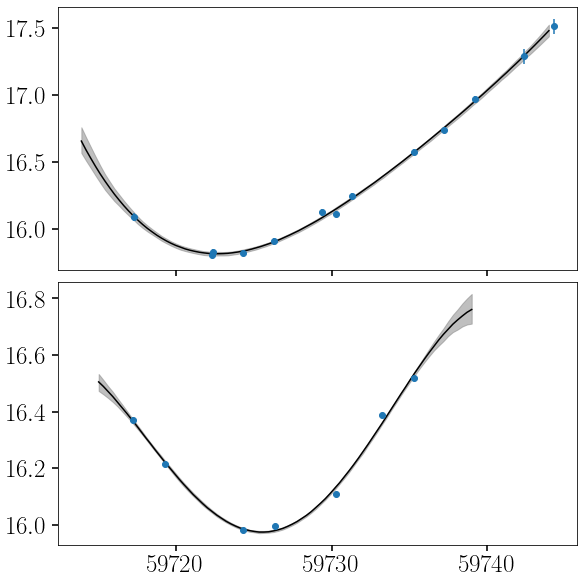

In [94]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8), sharex=True, constrained_layout=True)
# pred_ZTF = summary_pred.loc[summary_.index[:100]]
# pred_ATLAS = summary_pred.loc[summary_pred.index[100:]]
ax[0].plot(
    np.linspace(-10, 20, 100) + 59723.94,
    summary_pred_g_peak["mean"],
    color="k",
)
ax[0].fill_between(
    np.linspace(-10, 20, 100) + 59723.94,
    summary_pred_g_peak["hdi_16%"],
    summary_pred_g_peak["hdi_84%"],
    color="0.5",
    alpha=0.5,
)
ax[0].errorbar(
    joj_ZTF_g_peak["MJD"].values,
    joj_ZTF_g_peak["mag"].values,
    yerr=joj_ZTF_g_peak["mag_err_l"].values,
    fmt="o",
)

ax[1].plot(
    np.linspace(-10, 20, 100)[:80] + 59725.05,
    summary_pred_r_peak["mean"][:80],
    color="k",
)
ax[1].fill_between(
    np.linspace(-10, 20, 100)[:80] + 59725.05,
    summary_pred_r_peak["hdi_16%"][:80],
    summary_pred_r_peak["hdi_84%"][:80],
    color="0.5",
    alpha=0.5,
)
ax[1].errorbar(
    joj_ZTF_r_peak["MJD"].values[:80],
    joj_ZTF_r_peak["mag"].values[:80],
    yerr=joj_ZTF_r_peak["mag_err_l"].values[:80],
    fmt="o",
)

## Fit other SNe

In [95]:
# SN 2011fe
g_fe = np.loadtxt("./SN2011fe/SN2011fe_g_synthetic.dat")

t_fl_fe = 55796.687
t_max_mjd_fe = 55814.5

fe_g_peak = g_fe[
    ((g_fe[:, 0] - t_max_mjd_fe) / (1 + 0.0008) <= 20)
    & ((g_fe[:, 0] - t_max_mjd_fe) / (1 + 0.0008) >= -10)
]

trace_peak_fe = peak_poly_fit(
    MJD=fe_g_peak[:, 0],
    mag_obs=fe_g_peak[:, 1],
    mag_obs_unc=fe_g_peak[:, 2],
    z=0.0008,
    t_max_0=t_max_mjd_fe
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t_max, a4, a3, a2, a0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 25 seconds.


,mean,sd,hdi_16%,hdi_84%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
t_max,55814.874559,5.682200e-04,55814.873948,55814.875068,1.710000e-05,1.209000e-05,1116.425404,1358.064203,1.002746
a4,0.000010,1.000000e-08,0.000010,0.000010,0.000000e+00,0.000000e+00,1271.189027,1866.280974,1.002485
a3,-0.000340,1.200000e-07,-0.000340,-0.000339,0.000000e+00,0.000000e+00,1095.815042,1545.754375,1.003119
a2,0.006486,7.400000e-07,0.006485,0.006486,2.000000e-08,1.000000e-08,1675.532353,2259.011574,1.002272
a0,9.890724,2.240000e-05,9.890703,9.890746,5.300000e-07,3.800000e-07,1786.209394,2234.362789,1.000446
delta_m_15,0.796856,8.347000e-05,0.796770,0.796934,2.200000e-06,1.550000e-06,1452.120122,2260.022658,1.001483


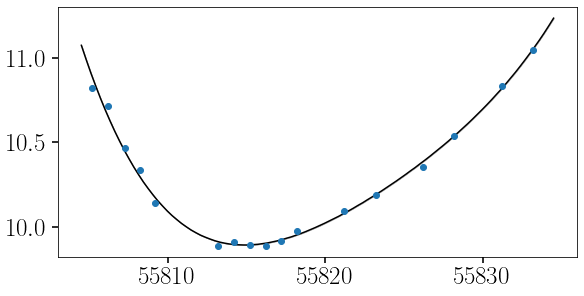

In [97]:
summary_fe = az.summary(
    trace_peak_fe,
    hdi_prob=0.68,
    round_to=8,
    var_names=[var for var in trace_peak_fe.posterior.data_vars if not "mag" in var],
)
summary_pred_fe = az.summary(
    trace_peak_fe,
    hdi_prob=0.68,
    var_names=[var for var in trace_peak_fe.posterior.data_vars if "pred" in var],
)
MJD_pred = np.linspace(-10, 20, 100) + t_max_mjd_fe
fig, ax = plt.subplots(figsize=(8, 4), sharex=True, constrained_layout=True)
# pred_ZTF = summary_pred.loc[summary_.index[:100]]
# pred_ATLAS = summary_pred.loc[summary_pred.index[100:]]
ax.plot(
    MJD_pred,
    summary_pred_fe["mean"],
    color="k",
)
ax.fill_between(
    MJD_pred,
    summary_pred_fe["hdi_16%"],
    summary_pred_fe["hdi_84%"],
    color="0.5",
    alpha=0.5,
)
ax.errorbar(
    fe_g_peak[:, 0],
    fe_g_peak[:, 1],
    yerr=fe_g_peak[:, 2],
    fmt="o",
)
summary_fe

In [102]:
# SN2018cnw
raw = pd.read_csv("./color/early18ia/ZTF18abauprj.dat", sep=" ")
lc_g = np.array(raw)[:, :-1][raw["fid"] == 1]  # determine the first detection

cnw_peak = lc_g[
    ((lc_g[:, 0]) <= 20)
    & ((lc_g[:, 0]) >= -10)
]

trace_peak_cnw = peak_poly_fit(
    MJD=cnw_peak[:, 0],
    mag_obs=cnw_peak[:, 1],
    mag_obs_unc=cnw_peak[:, 2],
    z=0.0242,
    t_max_0=0
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t_max, a4, a3, a2, a0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 25 seconds.


,mean,sd,hdi_16%,hdi_84%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
t_max,0.566898,8.126525e-02,0.487946,0.647095,2.483230e-03,1.772810e-03,1078.999064,1114.562650,1.000756
a4,0.000002,5.300000e-07,0.000001,0.000002,2.000000e-08,1.000000e-08,1092.914348,1350.077628,1.001715
a3,-0.000116,1.057000e-05,-0.000127,-0.000106,3.300000e-07,2.300000e-07,1032.888157,1069.684666,1.001163
a2,0.004794,5.639000e-05,0.004729,0.004841,1.310000e-06,9.300000e-07,1842.342489,2047.046874,0.999653
a0,-19.564166,2.522390e-03,-19.566477,-19.561455,5.866000e-05,4.149000e-05,1844.556874,1931.542814,0.999544
delta_m_15,0.772198,9.266650e-03,0.762895,0.781066,2.681400e-04,1.898300e-04,1200.510184,1540.572984,1.001374


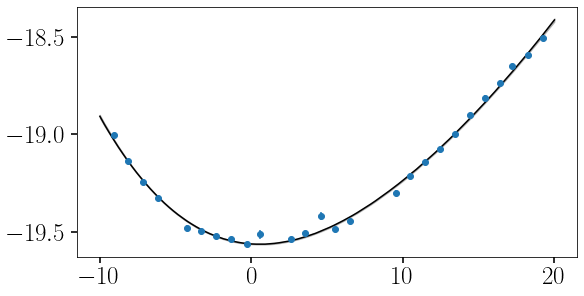

In [103]:
summary_cnw = az.summary(
    trace_peak_cnw,
    hdi_prob=0.68,
    round_to=8,
    var_names=[var for var in trace_peak_cnw.posterior.data_vars if not "mag" in var],
)
summary_pred_cnw = az.summary(
    trace_peak_cnw,
    hdi_prob=0.68,
    var_names=[var for var in trace_peak_cnw.posterior.data_vars if "pred" in var],
)
MJD_pred = np.linspace(-10, 20, 100)
fig, ax = plt.subplots(figsize=(8, 4), sharex=True, constrained_layout=True)
# pred_ZTF = summary_pred.loc[summary_.index[:100]]
# pred_ATLAS = summary_pred.loc[summary_pred.index[100:]]
ax.plot(
    MJD_pred,
    summary_pred_cnw["mean"],
    color="k",
)
ax.fill_between(
    MJD_pred,
    summary_pred_cnw["hdi_16%"],
    summary_pred_cnw["hdi_84%"],
    color="0.5",
    alpha=0.5,
)
ax.errorbar(
    cnw_peak[:, 0],
    cnw_peak[:, 1],
    yerr=cnw_peak[:, 2],
    fmt="o",
)
summary_cnw